In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
%%time
FILE_PATH = 'archive/'

user_file = open(FILE_PATH + "yelp_academic_dataset_user.json")

user_data = []
for line in user_file:
    user_data.append(json.loads(line))
user_file.close()

CPU times: user 8.13 s, sys: 1.91 s, total: 10 s
Wall time: 10.1 s


In [3]:
user_df = pd.DataFrame(user_data)
user_df.head()

user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  2WnXYQFK0hXEoTxPtV2zvg   Steph           665  2008-07-25 10:41:00    2086   
3  SZDeASXq7o05mMNLshsdIA    Gwen           224  2005-11-29 04:38:33     512   
4  hA5lMy-EnncsH4JoR-hFGQ   Karen            79  2007-01-05 19:40:59      29   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   1010   1003                           2009,2010,2011,2012,2013   
3    330    299                                     2009,2010,2011   
4     15      7                                                      

                                             friends  fans  ...  \
0  NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...   267  ...   
1  ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...  3138  ...   
2  LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...    52  ...   
3  enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...    28  ...   
4  PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...     1  ...   

   compliment_more  compliment_profile  compliment_cute  compliment_list  \
0               65                  55               56               18   
1              264                 184              157              251   
2               13                  10               17                3   
3                4                   1                6                2   
4                1                   0                0                0   

   compliment_note  compliment_plain  compliment_cool  compliment_funny  \
0              232               844              467               467   
1             1847              7054             3131              3131   
2               66                96              119               119   
3               12                16               26                26   
4                1                 1                0                 0   

   compliment_writer  compliment_photos  
0                239                180  
1               1521               1946  
2                 35                 18  
3                 10                  9  
4                  0                  0  

[5 rows x 22 columns]

In [4]:
user_df["yelping_since"] = pd.to_datetime(user_df["yelping_since"])

compl_cols = [c for c in user_df.columns if c.startswith("compliment_")]
user_df["compliments"] = user_df[compl_cols].sum(axis=1, min_count=1).fillna(0).astype("Int64")

to_drop = [c for c in ["name", "elite", "friends"] if c in user_df.columns]
user_df = user_df.drop(columns=to_drop)

In [5]:
print("Shape:", user_df.shape)
print("\nDTypes:\n", user_df.dtypes)

Shape: (1987897, 20)

DTypes:
 user_id                       object
review_count                   int64
yelping_since         datetime64[ns]
useful                         int64
funny                          int64
cool                           int64
fans                           int64
average_stars                float64
compliment_hot                 int64
compliment_more                int64
compliment_profile             int64
compliment_cute                int64
compliment_list                int64
compliment_note                int64
compliment_plain               int64
compliment_cool                int64
compliment_funny               int64
compliment_writer              int64
compliment_photos              int64
compliments                    Int64
dtype: object


In [6]:
num = ["review_count","useful","funny","cool","fans","compliments","average_stars"]
print(user_df[num].describe(percentiles=[.5,.9,.95,.99,.999]).T)

for c in ["review_count","useful","funny","cool","fans","compliments"]:
    z = (user_df[c]==0).mean()


                   count       mean         std  min   50%   90%    95%  \
review_count   1987897.0  23.394409   82.566992  0.0   5.0  47.0   92.0   
useful         1987897.0  42.296335  641.480597  0.0   3.0  46.0  105.0   
funny          1987897.0  16.970536  407.803437  0.0   0.0  11.0   28.0   
cool           1987897.0  23.792914  565.351295  0.0   0.0  13.0   35.0   
fans           1987897.0    1.46574   18.130753  0.0   0.0   2.0    4.0   
compliments    1987897.0  14.873109  547.134056  0.0   0.0   4.0   14.0   
average_stars  1987897.0   3.630494    1.183337  1.0  3.88   5.0    5.0   

                 99%     99.9%       max  
review_count   311.0     992.0   17473.0  
useful         573.0  4347.416  206296.0  
funny          202.0    2251.0  185823.0  
cool           286.0  3274.104  199878.0  
fans            26.0     150.0   12497.0  
compliments    133.0  2144.104  324328.0  
average_stars    5.0       5.0       5.0  


In [7]:
df = user_df.copy()

df["yelping_since"] = pd.to_datetime(df["yelping_since"], errors="coerce")

df = df[df["yelping_since"].notna()]

In [8]:
print("Date range:", df["yelping_since"].min(), "-", df["yelping_since"].max())

Date range: 2004-10-12 08:46:11 - 2022-01-19 17:15:47


In [9]:
df["start_month"] = df["yelping_since"].dt.to_period("M").dt.to_timestamp()  # first day of month
monthly = df.groupby("start_month").size().rename("users_started")

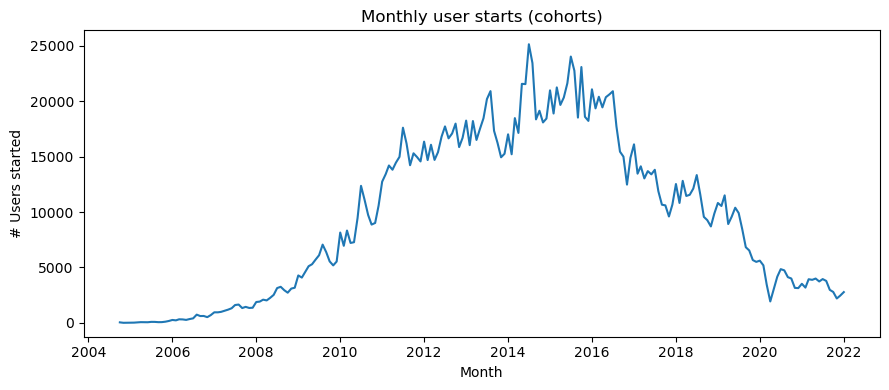

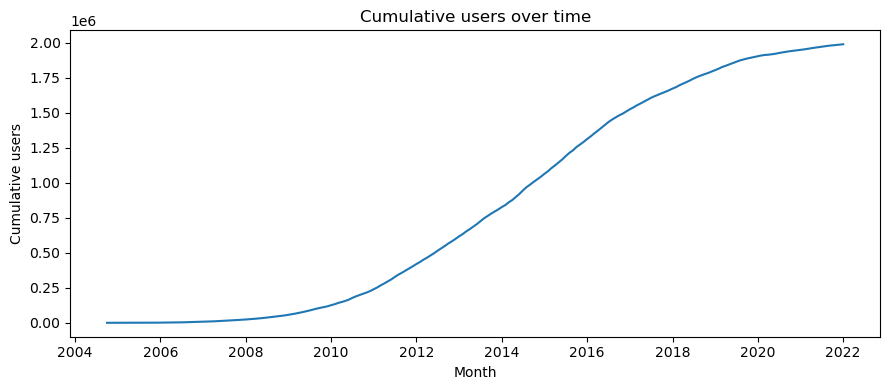

In [10]:
plt.figure(figsize=(9,4))
plt.plot(monthly.index, monthly.values)
plt.title("Monthly user starts (cohorts)")
plt.xlabel("Month")
plt.ylabel("# Users started")
plt.tight_layout()
plt.show()

cum = monthly.cumsum()

plt.figure(figsize=(9,4))
plt.plot(cum.index, cum.values)
plt.title("Cumulative users over time")
plt.xlabel("Month")
plt.ylabel("Cumulative users")
plt.tight_layout()
plt.show()

In [11]:
delta = (df["yelping_since"].max() - df["yelping_since"])
df["age_days_rel_latest"]   = delta.dt.days
df["age_months_rel_latest"] = (df["age_days_rel_latest"] / 30.4375)
df["age_years_rel_latest"]  = (df["age_days_rel_latest"] / 365.25)

print(df[["age_days_rel_latest","age_months_rel_latest","age_years_rel_latest"]].describe())

       age_days_rel_latest  age_months_rel_latest  age_years_rel_latest
count         1.987897e+06           1.987897e+06          1.987897e+06
mean          2.660822e+03           8.741919e+01          7.284933e+00
std           1.130979e+03           3.715742e+01          3.096451e+00
min           0.000000e+00           0.000000e+00          0.000000e+00
25%           1.880000e+03           6.176591e+01          5.147159e+00
50%           2.656000e+03           8.726078e+01          7.271732e+00
75%           3.490000e+03           1.146612e+02          9.555099e+00
max           6.308000e+03           2.072444e+02          1.727036e+01


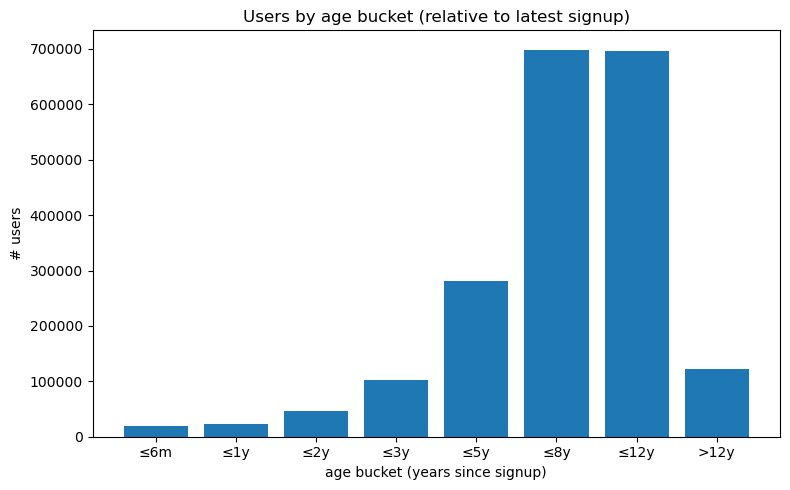

age_years_rel_latest
≤6m     0.009347
≤1y     0.011398
≤2y     0.023102
≤3y     0.051277
≤5y     0.141546
≤8y     0.351471
≤12y    0.350414
>12y    0.061444
Name: count, dtype: float64

In [12]:
bins = [0, 0.5, 1, 2, 3, 5, 8, 12, 20]  # years
labels = ["≤6m","≤1y","≤2y","≤3y","≤5y","≤8y","≤12y",">12y"]
cats = pd.cut(df["age_years_rel_latest"], bins=bins, labels=labels, right=True, include_lowest=True)
counts = cats.value_counts().reindex(labels)

plt.figure(figsize=(8,5))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Users by age bucket (relative to latest signup)")
plt.xlabel("age bucket (years since signup)")
plt.ylabel("# users")
plt.tight_layout()
plt.show()

(counts / counts.sum())

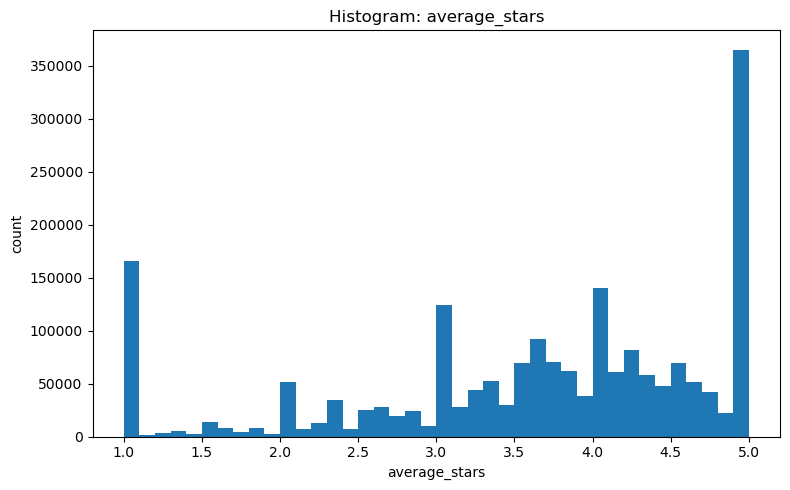

count    1.987897e+06
mean     3.630494e+00
std      1.183337e+00
min      1.000000e+00
25%      3.000000e+00
50%      3.880000e+00
75%      4.560000e+00
max      5.000000e+00
Name: average_stars, dtype: float64


In [13]:
plt.figure(figsize=(8,5))
plt.hist(df["average_stars"], bins=40)
plt.title("Histogram: average_stars")
plt.xlabel("average_stars"); plt.ylabel("count")
plt.tight_layout(); plt.show()

print(user_df['average_stars'].describe())

900803, 45.314%
405138, 20.380%
262609, 13.210%
233467, 11.744%
95061, 4.782%
69775, 3.510%
19095, 0.961%
1949, 0.098%


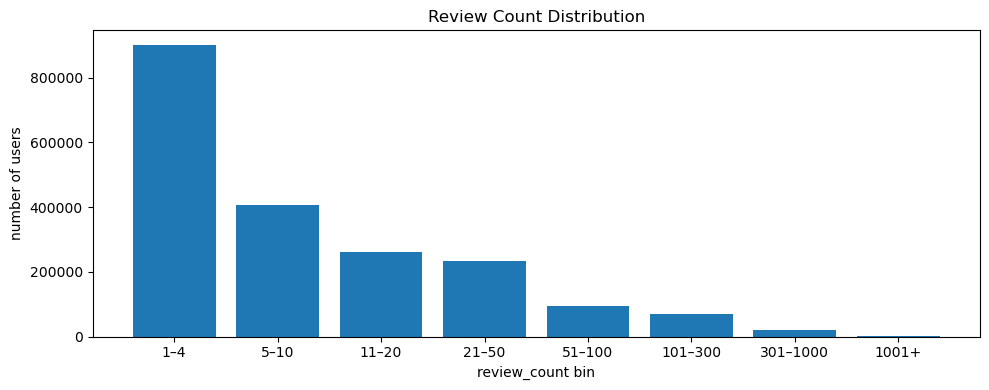

Mean: 23.3944
Standard Deviation: 82.5670
Range: 0 - 17473


In [14]:
x = user_df["review_count"]

labels = ["1–4", "5–10", "11–20", "21–50", "51–100", "101–300", "301–1000", "1001+"]


c1_4 = np.sum((x <= 4))
c5_10 = np.sum((x >= 5)  & (x <= 10))
c11_20 = np.sum((x >= 11) & (x <= 20))
c21_50 = np.sum((x >= 21) & (x <= 50))
c51_100 = np.sum((x >= 51) & (x <= 100))
c101_300 = np.sum((x >= 101) & (x <= 300))
c301_1000 = np.sum((x >= 301) & (x <= 1000))
c1001p = np.sum(x >= 1001)

counts = [c1_4, c5_10, c11_20, c21_50, c51_100, c101_300, c301_1000, c1001p]

for c in counts:
    print(f"{c}, {c/x.shape[0] * 100:.3f}%")

idx = np.arange(len(labels))

plt.figure(figsize=(10,4))
plt.bar(idx, counts)
plt.title("Review Count Distribution")
plt.xlabel("review_count bin")
plt.ylabel("number of users")
plt.xticks(idx, labels, rotation=0)
plt.tight_layout()
plt.show()


print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")


530210, 26.672%
416915, 20.973%
270124, 13.588%
214894, 10.810%
189685, 9.542%
180243, 9.067%
82041, 4.127%
65691, 3.305%
27260, 1.371%
9182, 0.462%
1652, 0.083%


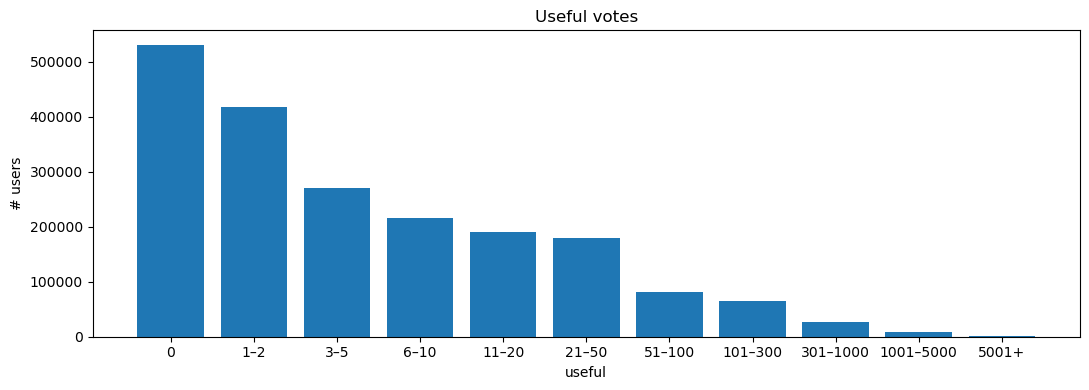

Mean: 42.2963
Standard Deviation: 641.4806
Range: 0 - 206296


In [15]:

x = user_df["useful"]

labels = ["0","1–2","3–5","6–10","11–20","21–50","51–100","101–300","301–1000","1001–5000","5001+"]
c0      = np.sum(x == 0)
c1_2    = np.sum((x >= 1) & (x <= 2))
c3_5    = np.sum((x >= 3) & (x <= 5))
c6_10   = np.sum((x >= 6) & (x <= 10))
c11_20  = np.sum((x >= 11) & (x <= 20))
c21_50  = np.sum((x >= 21) & (x <= 50))
c51_100 = np.sum((x >= 51) & (x <= 100))
c101_300= np.sum((x >= 101) & (x <= 300))
c301_1k = np.sum((x >= 301) & (x <= 1000))
c1k_5k  = np.sum((x >= 1001) & (x <= 5000))
c5kp    = np.sum(x >= 5001)

counts = [c0,c1_2,c3_5,c6_10,c11_20,c21_50,c51_100,c101_300,c301_1k,c1k_5k,c5kp]


for c in counts:
    print(f"{c}, {c/x.shape[0] * 100:.3f}%")
    
idx = np.arange(len(labels));
plt.figure(figsize=(11,4)); plt.bar(idx, counts)
plt.title("Useful votes"); plt.xlabel("useful"); plt.ylabel("# users")
plt.xticks(idx, labels, rotation=0)
plt.tight_layout()
plt.show()


print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")


1097703, 55.219%
399115, 20.077%
178075, 8.958%
109242, 5.495%
78725, 3.960%
62730, 3.156%
26572, 1.337%
21774, 1.095%
9361, 0.471%
4600, 0.231%


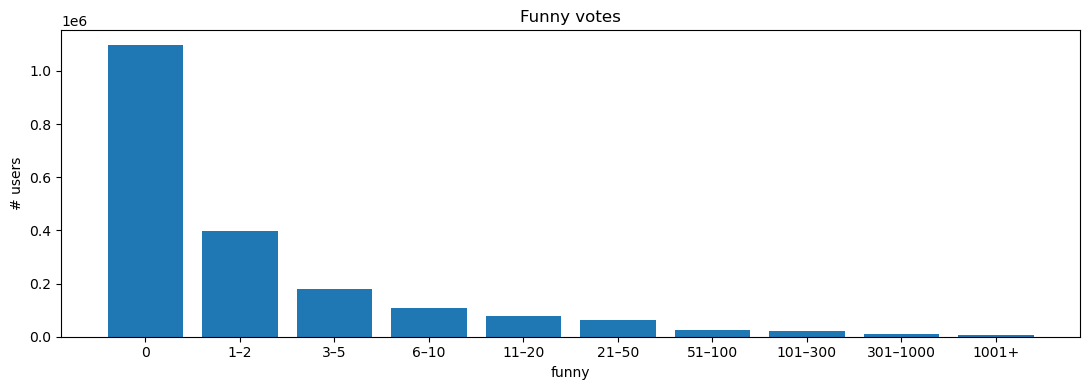

Mean: 16.9705
Standard Deviation: 407.8034
Range: 0 - 185823


In [16]:
x = user_df["funny"]

labels = ["0","1–2","3–5","6–10","11–20","21–50","51–100","101–300","301–1000","1001+"]
c0      = np.sum(x == 0)
c1_2    = np.sum((x >= 1) & (x <= 2))
c3_5    = np.sum((x >= 3) & (x <= 5))
c6_10   = np.sum((x >= 6) & (x <= 10))
c11_20  = np.sum((x >= 11) & (x <= 20))
c21_50  = np.sum((x >= 21) & (x <= 50))
c51_100 = np.sum((x >= 51) & (x <= 100))
c101_300= np.sum((x >= 101) & (x <= 300))
c301_1k = np.sum((x >= 301) & (x <= 1000))
c1kp    = np.sum(x >= 1001)

counts = [c0,c1_2,c3_5,c6_10,c11_20,c21_50,c51_100,c101_300,c301_1k,c1kp]


for c in counts:
    print(f"{c}, {c/x.shape[0] * 100:.3f}%")
    
idx = np.arange(len(labels))

plt.figure(figsize=(11,4))
plt.bar(idx, counts)
plt.title("Funny votes")
plt.xlabel("funny")
plt.ylabel("# users")
plt.xticks(idx, labels)
plt.tight_layout()
plt.show()

# print(x.describe())

print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")





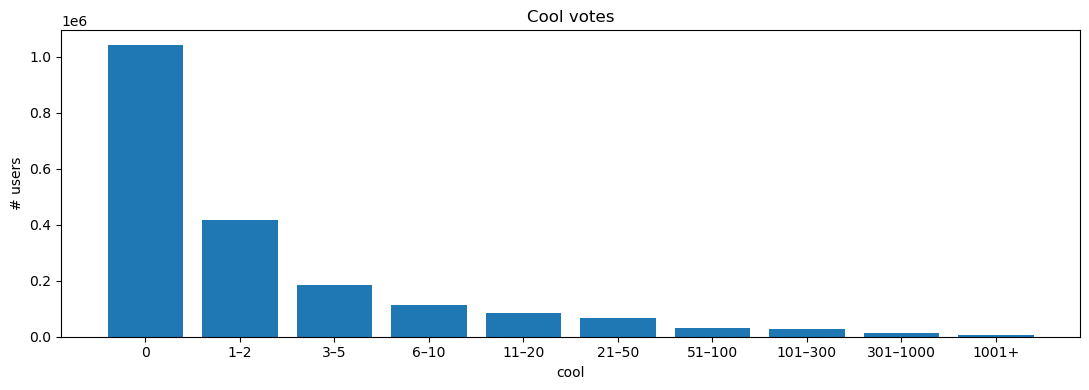

Mean: 23.7929
Standard Deviation: 565.3513
Range: 0 - 199878


In [17]:

x = user_df["cool"]

labels = ["0","1–2","3–5","6–10","11–20","21–50","51–100","101–300","301–1000","1001+"]
c0      = np.sum(x == 0)
c1_2    = np.sum((x >= 1) & (x <= 2))
c3_5    = np.sum((x >= 3) & (x <= 5))
c6_10   = np.sum((x >= 6) & (x <= 10))
c11_20  = np.sum((x >= 11) & (x <= 20))
c21_50  = np.sum((x >= 21) & (x <= 50))
c51_100 = np.sum((x >= 51) & (x <= 100))
c101_300= np.sum((x >= 101) & (x <= 300))
c301_1k = np.sum((x >= 301) & (x <= 1000))
c1kp    = np.sum(x >= 1001)

counts = [c0,c1_2,c3_5,c6_10,c11_20,c21_50,c51_100,c101_300,c301_1k,c1kp]
idx = np.arange(len(labels))
plt.figure(figsize=(11,4))
plt.bar(idx, counts)
plt.title("Cool votes")
plt.xlabel("cool")
plt.ylabel("# users")
plt.xticks(idx, labels)
plt.tight_layout()
plt.show()


print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")


1577870, 79.374%
199819, 10.052%
65897, 3.315%
64784, 3.259%
32092, 1.614%
21884, 1.101%
16396, 0.825%
5517, 0.278%
2991, 0.150%
647, 0.033%


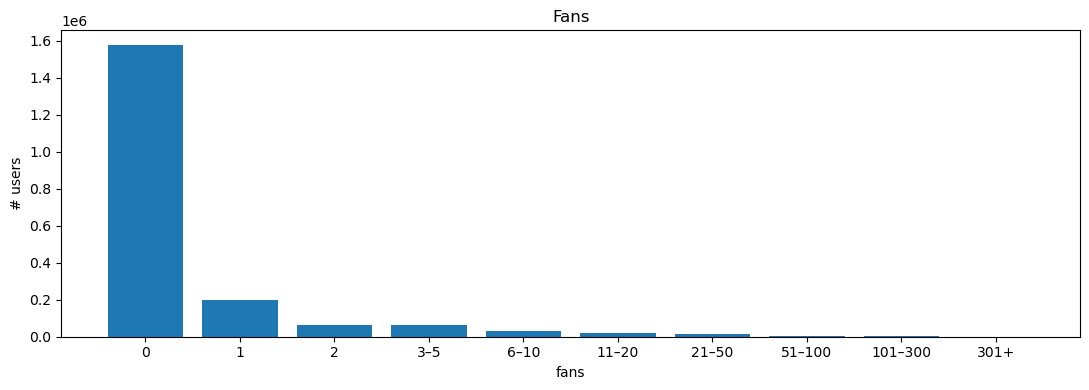

Mean: 1.4657
Standard Deviation: 18.1308
Range: 0 - 12497


In [18]:
x = user_df["fans"]

labels = ["0","1","2","3–5","6–10","11–20","21–50","51–100","101–300","301+"]
c0     = np.sum(x == 0)
c1     = np.sum(x == 1)
c2     = np.sum(x == 2)
c3_5   = np.sum((x >= 3) & (x <= 5))
c6_10  = np.sum((x >= 6) & (x <= 10))
c11_20 = np.sum((x >= 11) & (x <= 20))
c21_50 = np.sum((x >= 21) & (x <= 50))
c51_100= np.sum((x >= 51) & (x <= 100))
c101_300=np.sum((x >= 101) & (x <= 300))
c301p  = np.sum(x >= 301)

counts = [c0,c1,c2,c3_5,c6_10,c11_20,c21_50,c51_100,c101_300,c301p]


for c in counts:
    print(f"{c}, {c/x.shape[0] * 100:.3f}%")
    
idx = np.arange(len(labels))
plt.figure(figsize=(11,4))
plt.bar(idx, counts)
plt.title("Fans")
plt.xlabel("fans")
plt.ylabel("# users")
plt.xticks(idx, labels)
plt.tight_layout()
plt.show()


print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")



1366367, 68.734%
332147, 16.708%
114636, 5.767%
57645, 2.900%
38911, 1.957%
35776, 1.800%
17441, 0.877%
14731, 0.741%
6423, 0.323%
2945, 0.148%
875, 0.044%


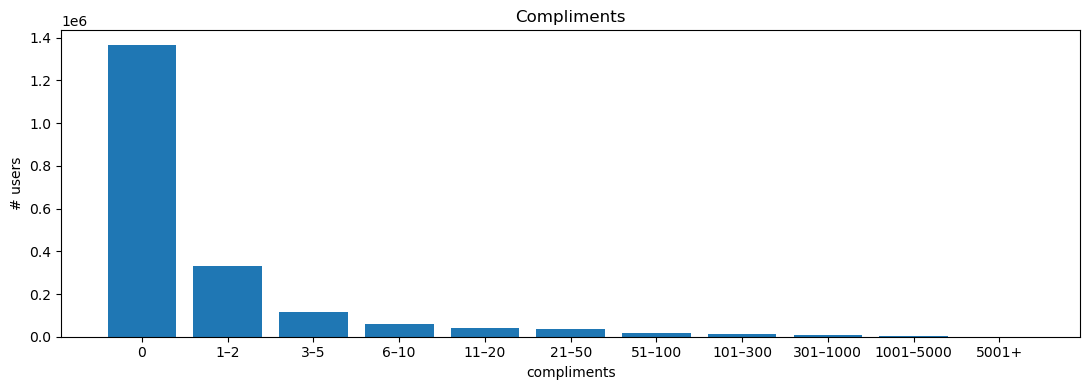

Mean: 14.8731
Standard Deviation: 547.1341
Range: 0 - 324328


In [19]:

x = user_df["compliments"]

labels = ["0","1–2","3–5","6–10","11–20","21–50","51–100","101–300","301–1000","1001–5000","5001+"]
c0      = np.sum(x == 0)
c1_2    = np.sum((x >= 1) & (x <= 2))
c3_5    = np.sum((x >= 3) & (x <= 5))
c6_10   = np.sum((x >= 6) & (x <= 10))
c11_20  = np.sum((x >= 11) & (x <= 20))
c21_50  = np.sum((x >= 21) & (x <= 50))
c51_100 = np.sum((x >= 51) & (x <= 100))
c101_300= np.sum((x >= 101) & (x <= 300))
c301_1k = np.sum((x >= 301) & (x <= 1000))
c1k_5k  = np.sum((x >= 1001) & (x <= 5000))
c5kp    = np.sum(x >= 5001)

counts = [c0,c1_2,c3_5,c6_10,c11_20,c21_50,c51_100,c101_300,c301_1k,c1k_5k,c5kp]


for c in counts:
    print(f"{c}, {c/x.shape[0] * 100:.3f}%")
idx = np.arange(len(labels))
plt.figure(figsize=(11,4))
plt.bar(idx, counts)
plt.title("Compliments")
plt.xlabel("compliments")
plt.ylabel("# users")
plt.xticks(idx, labels)
plt.tight_layout()
plt.show()


print(f"Mean: {x.mean():.4f}")
print(f"Standard Deviation: {x.std():.4f}")
print(f"Range: {x.min()} - {x.max()}")


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [21]:
drop_cols = ["compliment_hot","compliment_more","compliment_profile","compliment_cute",
    "compliment_list","compliment_note","compliment_plain","compliment_cool",
    "compliment_funny","compliment_writer","compliment_photos"]

log_cols = ['review_count', "useful", "funny", "cool", "fans", "compliments"]

for col in drop_cols:
    if col in user_df.columns:
        user_df.drop(col, axis=1, inplace=True)
user_df

user_id  review_count       yelping_since  useful  \
0        qVc8ODYU5SZjKXVBgXdI7w           585 2007-01-25 16:47:26    7217   
1        j14WgRoU_-2ZE1aw1dXrJg          4333 2009-01-25 04:35:42   43091   
2        2WnXYQFK0hXEoTxPtV2zvg           665 2008-07-25 10:41:00    2086   
3        SZDeASXq7o05mMNLshsdIA           224 2005-11-29 04:38:33     512   
4        hA5lMy-EnncsH4JoR-hFGQ            79 2007-01-05 19:40:59      29   
...                         ...           ...                 ...     ...   
1987892  fB3jbHi3m0L2KgGOxBv6uw            23 2015-01-06 00:31:31       7   
1987893  68czcr4BxJyMQ9cJBm6C7Q             1 2016-06-14 07:20:52       0   
1987894  1x3KMskYxOuJCjRz70xOqQ             4 2017-02-04 15:31:58       1   
1987895  ulfGl4tdbrH05xKzh5lnog             2 2011-01-14 00:29:08       0   
1987896  wL5jPrLRVCK_Pmo4lM1zpA             2 2020-12-19 02:32:39       0   

         funny   cool  fans  average_stars  compliments  
0         1259   5994   267           3.91         2873  
1        13066  27281  3138           3.74        20631  
2         1010   1003    52           3.32          585  
3          330    299    28           4.27          136  
4           15      7     1           3.54            4  
...        ...    ...   ...            ...          ...  
1987892      0      0     0           4.92            0  
1987893      0      0     0           5.00            0  
1987894      1      0     0           2.00            0  
1987895      0      0     0           3.00            0  
1987896      0      0     0           5.00            0  

[1987897 rows x 9 columns]

In [26]:
for col in log_cols:
    if col in user_df.columns:
        user_df[f"log_{col}"] = user_df[col].apply(np.log1p)
user_df

user_id  review_count       yelping_since  \
0        qVc8ODYU5SZjKXVBgXdI7w           585 2007-01-25 16:47:26   
1        j14WgRoU_-2ZE1aw1dXrJg          4333 2009-01-25 04:35:42   
2        2WnXYQFK0hXEoTxPtV2zvg           665 2008-07-25 10:41:00   
3        SZDeASXq7o05mMNLshsdIA           224 2005-11-29 04:38:33   
4        hA5lMy-EnncsH4JoR-hFGQ            79 2007-01-05 19:40:59   
...                         ...           ...                 ...   
1987892  fB3jbHi3m0L2KgGOxBv6uw            23 2015-01-06 00:31:31   
1987893  68czcr4BxJyMQ9cJBm6C7Q             1 2016-06-14 07:20:52   
1987894  1x3KMskYxOuJCjRz70xOqQ             4 2017-02-04 15:31:58   
1987895  ulfGl4tdbrH05xKzh5lnog             2 2011-01-14 00:29:08   
1987896  wL5jPrLRVCK_Pmo4lM1zpA             2 2020-12-19 02:32:39   

         average_stars  log_useful  log_funny   log_cool  log_fans  \
0                 3.91    8.884333   7.138867   8.698681  5.590987   
1                 3.74   10.671093   9.477845  10.213982  8.051660   
2                 3.32    7.643483   6.918695   6.911747  3.970292   
3                 4.27    6.240276   5.802118   5.703782  3.367296   
4                 3.54    3.401197   2.772589   2.079442  0.693147   
...                ...         ...        ...        ...       ...   
1987892           4.92    2.079442   0.000000   0.000000  0.000000   
1987893           5.00    0.000000   0.000000   0.000000  0.000000   
1987894           2.00    0.693147   0.693147   0.000000  0.000000   
1987895           3.00    0.000000   0.000000   0.000000  0.000000   
1987896           5.00    0.000000   0.000000   0.000000  0.000000   

         log_compliments  log_review_count  
0                7.96346          6.373320  
1               9.934599          8.374246  
2                6.37332          6.501290  
3               4.919981          5.416100  
4               1.609438          4.382027  
...                  ...               ...  
1987892              0.0          3.178054  
1987893              0.0          0.693147  
1987894              0.0          1.609438  
1987895              0.0          1.098612  
1987896              0.0          1.098612  

[1987897 rows x 10 columns]

In [27]:
for col in log_cols:
    if col in user_df.columns:
        user_df.drop(col, axis=1, inplace=True)
user_df

user_id       yelping_since  average_stars  \
0        qVc8ODYU5SZjKXVBgXdI7w 2007-01-25 16:47:26           3.91   
1        j14WgRoU_-2ZE1aw1dXrJg 2009-01-25 04:35:42           3.74   
2        2WnXYQFK0hXEoTxPtV2zvg 2008-07-25 10:41:00           3.32   
3        SZDeASXq7o05mMNLshsdIA 2005-11-29 04:38:33           4.27   
4        hA5lMy-EnncsH4JoR-hFGQ 2007-01-05 19:40:59           3.54   
...                         ...                 ...            ...   
1987892  fB3jbHi3m0L2KgGOxBv6uw 2015-01-06 00:31:31           4.92   
1987893  68czcr4BxJyMQ9cJBm6C7Q 2016-06-14 07:20:52           5.00   
1987894  1x3KMskYxOuJCjRz70xOqQ 2017-02-04 15:31:58           2.00   
1987895  ulfGl4tdbrH05xKzh5lnog 2011-01-14 00:29:08           3.00   
1987896  wL5jPrLRVCK_Pmo4lM1zpA 2020-12-19 02:32:39           5.00   

         log_useful  log_funny   log_cool  log_fans  log_compliments  \
0          8.884333   7.138867   8.698681  5.590987          7.96346   
1         10.671093   9.477845  10.213982  8.051660         9.934599   
2          7.643483   6.918695   6.911747  3.970292          6.37332   
3          6.240276   5.802118   5.703782  3.367296         4.919981   
4          3.401197   2.772589   2.079442  0.693147         1.609438   
...             ...        ...        ...       ...              ...   
1987892    2.079442   0.000000   0.000000  0.000000              0.0   
1987893    0.000000   0.000000   0.000000  0.000000              0.0   
1987894    0.693147   0.693147   0.000000  0.000000              0.0   
1987895    0.000000   0.000000   0.000000  0.000000              0.0   
1987896    0.000000   0.000000   0.000000  0.000000              0.0   

         log_review_count  
0                6.373320  
1                8.374246  
2                6.501290  
3                5.416100  
4                4.382027  
...                   ...  
1987892          3.178054  
1987893          0.693147  
1987894          1.609438  
1987895          1.098612  
1987896          1.098612  

[1987897 rows x 9 columns]

In [29]:
import pandas as pd

out = user_df.copy()

ys = pd.to_datetime(out["yelping_since"])
out["yelping_since"] = ys.dt.strftime("%Y-%m-%d %H:%M:%S")

desired_order = [
    "user_id", "log_review_count", "yelping_since", "average_stars", "log_useful", "log_funny", "log_cool", "log_fans",
    # "compliment_hot","compliment_more","compliment_profile","compliment_cute",
    # "compliment_list","compliment_note","compliment_plain","compliment_cool",
    # "compliment_funny","compliment_writer","compliment_photos",
    "log_compliments"  
]
cols = [c for c in desired_order if c in out.columns] #+ [c for c in out.columns if c not in desired_order]
out = out[cols]

#out.to_json("yelp_user_clean.json", orient="records", lines=True, force_ascii=False)


In [30]:
out

user_id  log_review_count        yelping_since  \
0        qVc8ODYU5SZjKXVBgXdI7w          6.373320  2007-01-25 16:47:26   
1        j14WgRoU_-2ZE1aw1dXrJg          8.374246  2009-01-25 04:35:42   
2        2WnXYQFK0hXEoTxPtV2zvg          6.501290  2008-07-25 10:41:00   
3        SZDeASXq7o05mMNLshsdIA          5.416100  2005-11-29 04:38:33   
4        hA5lMy-EnncsH4JoR-hFGQ          4.382027  2007-01-05 19:40:59   
...                         ...               ...                  ...   
1987892  fB3jbHi3m0L2KgGOxBv6uw          3.178054  2015-01-06 00:31:31   
1987893  68czcr4BxJyMQ9cJBm6C7Q          0.693147  2016-06-14 07:20:52   
1987894  1x3KMskYxOuJCjRz70xOqQ          1.609438  2017-02-04 15:31:58   
1987895  ulfGl4tdbrH05xKzh5lnog          1.098612  2011-01-14 00:29:08   
1987896  wL5jPrLRVCK_Pmo4lM1zpA          1.098612  2020-12-19 02:32:39   

         average_stars  log_useful  log_funny   log_cool  log_fans  \
0                 3.91    8.884333   7.138867   8.698681  5.590987   
1                 3.74   10.671093   9.477845  10.213982  8.051660   
2                 3.32    7.643483   6.918695   6.911747  3.970292   
3                 4.27    6.240276   5.802118   5.703782  3.367296   
4                 3.54    3.401197   2.772589   2.079442  0.693147   
...                ...         ...        ...        ...       ...   
1987892           4.92    2.079442   0.000000   0.000000  0.000000   
1987893           5.00    0.000000   0.000000   0.000000  0.000000   
1987894           2.00    0.693147   0.693147   0.000000  0.000000   
1987895           3.00    0.000000   0.000000   0.000000  0.000000   
1987896           5.00    0.000000   0.000000   0.000000  0.000000   

         log_compliments  
0                7.96346  
1               9.934599  
2                6.37332  
3               4.919981  
4               1.609438  
...                  ...  
1987892              0.0  
1987893              0.0  
1987894              0.0  
1987895              0.0  
1987896              0.0  

[1987897 rows x 9 columns]

In [32]:
out.to_csv("yelp_user_clean.csv", index=False)


In [ ]:
# json_file = open('yelp_user_clean.json')
# json_data = []

# for line in json_file:
#     json_data.append(json.loads(line))
# json_df = pd.DataFrame(json_data)
# json_file.close()

In [35]:
csv_file = pd.read_csv('yelp_user_clean.csv')

In [36]:
csv_file

user_id  log_review_count        yelping_since  \
0        qVc8ODYU5SZjKXVBgXdI7w          6.373320  2007-01-25 16:47:26   
1        j14WgRoU_-2ZE1aw1dXrJg          8.374246  2009-01-25 04:35:42   
2        2WnXYQFK0hXEoTxPtV2zvg          6.501290  2008-07-25 10:41:00   
3        SZDeASXq7o05mMNLshsdIA          5.416100  2005-11-29 04:38:33   
4        hA5lMy-EnncsH4JoR-hFGQ          4.382027  2007-01-05 19:40:59   
...                         ...               ...                  ...   
1987892  fB3jbHi3m0L2KgGOxBv6uw          3.178054  2015-01-06 00:31:31   
1987893  68czcr4BxJyMQ9cJBm6C7Q          0.693147  2016-06-14 07:20:52   
1987894  1x3KMskYxOuJCjRz70xOqQ          1.609438  2017-02-04 15:31:58   
1987895  ulfGl4tdbrH05xKzh5lnog          1.098612  2011-01-14 00:29:08   
1987896  wL5jPrLRVCK_Pmo4lM1zpA          1.098612  2020-12-19 02:32:39   

         average_stars  log_useful  log_funny   log_cool  log_fans  \
0                 3.91    8.884333   7.138867   8.698681  5.590987   
1                 3.74   10.671093   9.477845  10.213982  8.051660   
2                 3.32    7.643483   6.918695   6.911747  3.970292   
3                 4.27    6.240276   5.802118   5.703782  3.367296   
4                 3.54    3.401197   2.772589   2.079442  0.693147   
...                ...         ...        ...        ...       ...   
1987892           4.92    2.079442   0.000000   0.000000  0.000000   
1987893           5.00    0.000000   0.000000   0.000000  0.000000   
1987894           2.00    0.693147   0.693147   0.000000  0.000000   
1987895           3.00    0.000000   0.000000   0.000000  0.000000   
1987896           5.00    0.000000   0.000000   0.000000  0.000000   

         log_compliments  
0               7.963460  
1               9.934599  
2               6.373320  
3               4.919981  
4               1.609438  
...                  ...  
1987892         0.000000  
1987893         0.000000  
1987894         0.000000  
1987895         0.000000  
1987896         0.000000  

[1987897 rows x 9 columns]